# 01_setup_y_descarga

In [ ]:
# Celda 1: Subir kaggle.json
from google.colab import files

print("📁 Por favor, sube tu archivo kaggle.json")
print("   (El que acabas de descargar de Kaggle)")

uploaded = files.upload()

📁 Por favor, sube tu archivo kaggle.json
   (El que acabas de descargar de Kaggle)


In [ ]:
import os

# Crear carpeta .kaggle
!mkdir -p ~/.kaggle

# Copiar el archivo kaggle.json a la carpeta correcta
!cp kaggle.json ~/.kaggle/

# Darle permisos correctos (seguridad)
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API configurada correctamente!")

✅ Kaggle API configurada correctamente!


In [ ]:
!pip install -q kaggle

print("✅ Kaggle instalado!")

✅ Kaggle instalado!


In [ ]:
#Descargar Dataset
print("Descargando dataset de rayos x...")

#crear carpeta para los datos
!mkdir -p /content/data

#desacarga dataset de kaggle
!kaggle datasets download -d muhammadrehan00/chest-xray-dataset -p /content/data

print("Descarga completada!")

Descargando dataset de rayos x...
Dataset URL: https://www.kaggle.com/datasets/muhammadrehan00/chest-xray-dataset
License(s): CC-BY-NC-SA-4.0
chest-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Descarga completada!


In [ ]:
#Descomprimir dataset
import zipfile

print("Descomprimiendo dataset...")

#Descomprimir
with zipfile.ZipFile('/content/data/chest-xray-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/data')

print("Dataset descomprimido!")


Descomprimiendo dataset...
Dataset descomprimido!


In [ ]:
print("Estructura del dataset")
print("="*50)

#listar carpetas principales
data_path = "/content/data"

for folder in os.listdir(data_path):
  folder_path = os.path.join(data_path, folder)
  if os.path.isdir(folder_path):
    print(f"\n {folder}")
    #listar subcarpetas
    for subfolder in os.listdir(folder_path):
      subfolder_path = os.path.join(folder_path, subfolder)
      if os.path.isdir(subfolder_path):
        #contar imagenes
        num_images = len([f for f in os.listdir(subfolder_path)
                          if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"└─ {subfolder}: {num_images} imágenes")
print("\n" + "="*50)



Estructura del dataset

 test
└─ pneumonia: 580 imágenes
└─ tuberculosis: 1064 imágenes
└─ normal: 925 imágenes

 train
└─ pneumonia: 4674 imágenes
└─ tuberculosis: 8513 imágenes
└─ normal: 7263 imágenes

 val
└─ pneumonia: 570 imágenes
└─ tuberculosis: 1064 imágenes
└─ normal: 900 imágenes



# 02_analisis_exploratorio

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

#configurar estilo de gráficos
plt.style.use('default')
sns.set_palette('husl')

In [32]:
def analyze_dataset_distribution(data_path):
  #Función que analiza la distribución de imágenes del dataset
  data_path = Path(data_path)
  #Diccionario ppara guardar estadísticas
  stats = {
      'split': [],
      'class': [],
      'count': []
  }

  #Explorar cada split
  for split in ['train', 'val', 'test']:
    split_path = data_path / split
    if not split_path.exists():
      continue
    #Explorar cada clase
    for class_name in os.listdir(split_path):
      class_path = split_path / class_name
      #Contar imágenes
      if class_path.exists():
        #Cuenta los archivos contenidos en las carpes evitando carpetas adicionales o archivos ocultos.
        num_images = len([f for f in os.listdir(class_path)
                     if os.path.isfile(os.path.join(class_path, f))
                     and not f.startswith('.')])

        #Guardar estadísticas
        stats['split'].append(split)
        stats['class'].append(class_name)
        stats['count'].append(num_images)
  return pd.DataFrame(stats)

df_stats = analyze_dataset_distribution(data_path)

print("📊 DISTRIBUCIÓN DEL DATASET")
print("=" * 60)
print(df_stats)
print("=" * 60)

📊 DISTRIBUCIÓN DEL DATASET
   split         class  count
0  train     pneumonia   4674
1  train  tuberculosis   8513
2  train        normal   7263
3    val     pneumonia    570
4    val  tuberculosis   1064
5    val        normal    900
6   test     pneumonia    580
7   test  tuberculosis   1064
8   test        normal    925


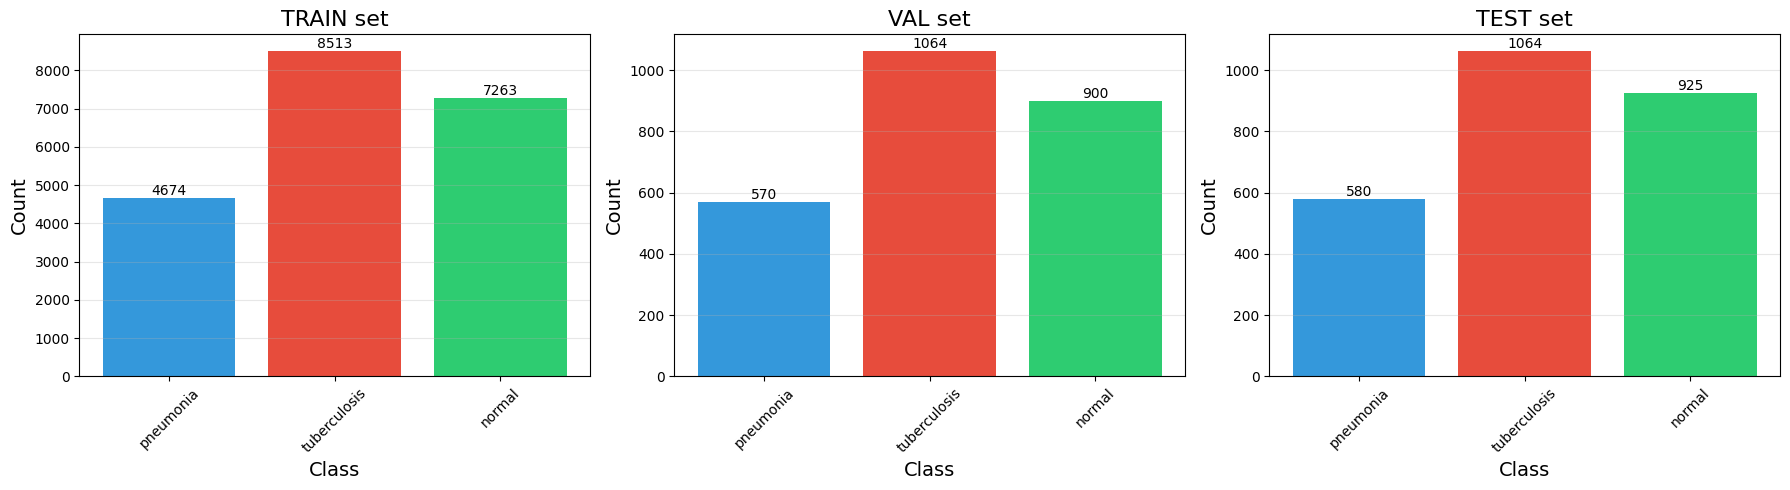

totales por clase:
totals: class
normal           9088
pneumonia        5824
tuberculosis    10641
Name: count, dtype: int64, 
 percentage: class
normal          35.565296
pneumonia       22.791844
tuberculosis    41.642860
Name: count, dtype: float64


In [34]:
#Visualización de distribución

fig,axes = plt.subplots(1,3, figsize = (18,5))

splits = ['train', 'val', 'test']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, split in enumerate(splits):
  split_df = df_stats[df_stats['split'] == split]

  ax = axes[i]
  bars = ax.bar(split_df['class'], split_df['count'], color = colors)

  #Agregar valores encima de las barras
  for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha = 'center', va = 'bottom')

  ax.set_title(f'{split.upper()} set', fontsize = 16)
  ax.set_xlabel('Class', fontsize = 14)
  ax.set_ylabel('Count', fontsize = 14)
  ax.tick_params(axis = 'x', rotation = 45)
  ax.grid(axis = 'y', alpha = 0.3)

plt.tight_layout()
plt.show()

print("totales por clase:")
totals = df_stats.groupby('class')['count'].sum()
percentage = totals / totals.sum() * 100
print(f"totals: {totals}, \n percentage: {percentage}")

In [41]:
#Análisis de desbalance de clases

train_data = df_stats[df_stats['split'] == 'train']
count = train_data['count'].values
max_count = np.max(count)
min_count = np.min(count)
ratio = max_count / min_count

print(f"Clase con más imágenes: {train_data[train_data['count']==max_count]['class'].values[0]}")
print(f"Número de imágenes:{max_count}")
print(f"Clase con menos imágenes: {train_data[train_data['count']==min_count]['class'].values[0]}")
print(f"Número de imágenes:{min_count}")
print(f"Ratio de desbalance: {ratio}")

if ratio>2:
  print("Dataset significativamente desbalanceado")
  print("\n💡 Recomendaciones:")
  print("   1. Usar 'class weights' en la función de pérdida")
  print("   2. Considerar técnicas de data augmentation más agresivas")
  print("   3. Evaluar con métricas balanceadas (F1-score, no solo accuracy)")
elif ratio > 1.5:
  print("Dataset levemente desbalanceado")
  print("\n💡 Recomendación: Usar class weights")
else:
  print("Dataset razonablemente balanceado")


Clase con más imágenes: tuberculosis
Número de imágenes:8513
Clase con menos imágenes: pneumonia
Número de imágenes:4674
Ratio de desbalance: 1.82135216089003
Dataset levemente desbalanceado

💡 Recomendación: Usar class weights


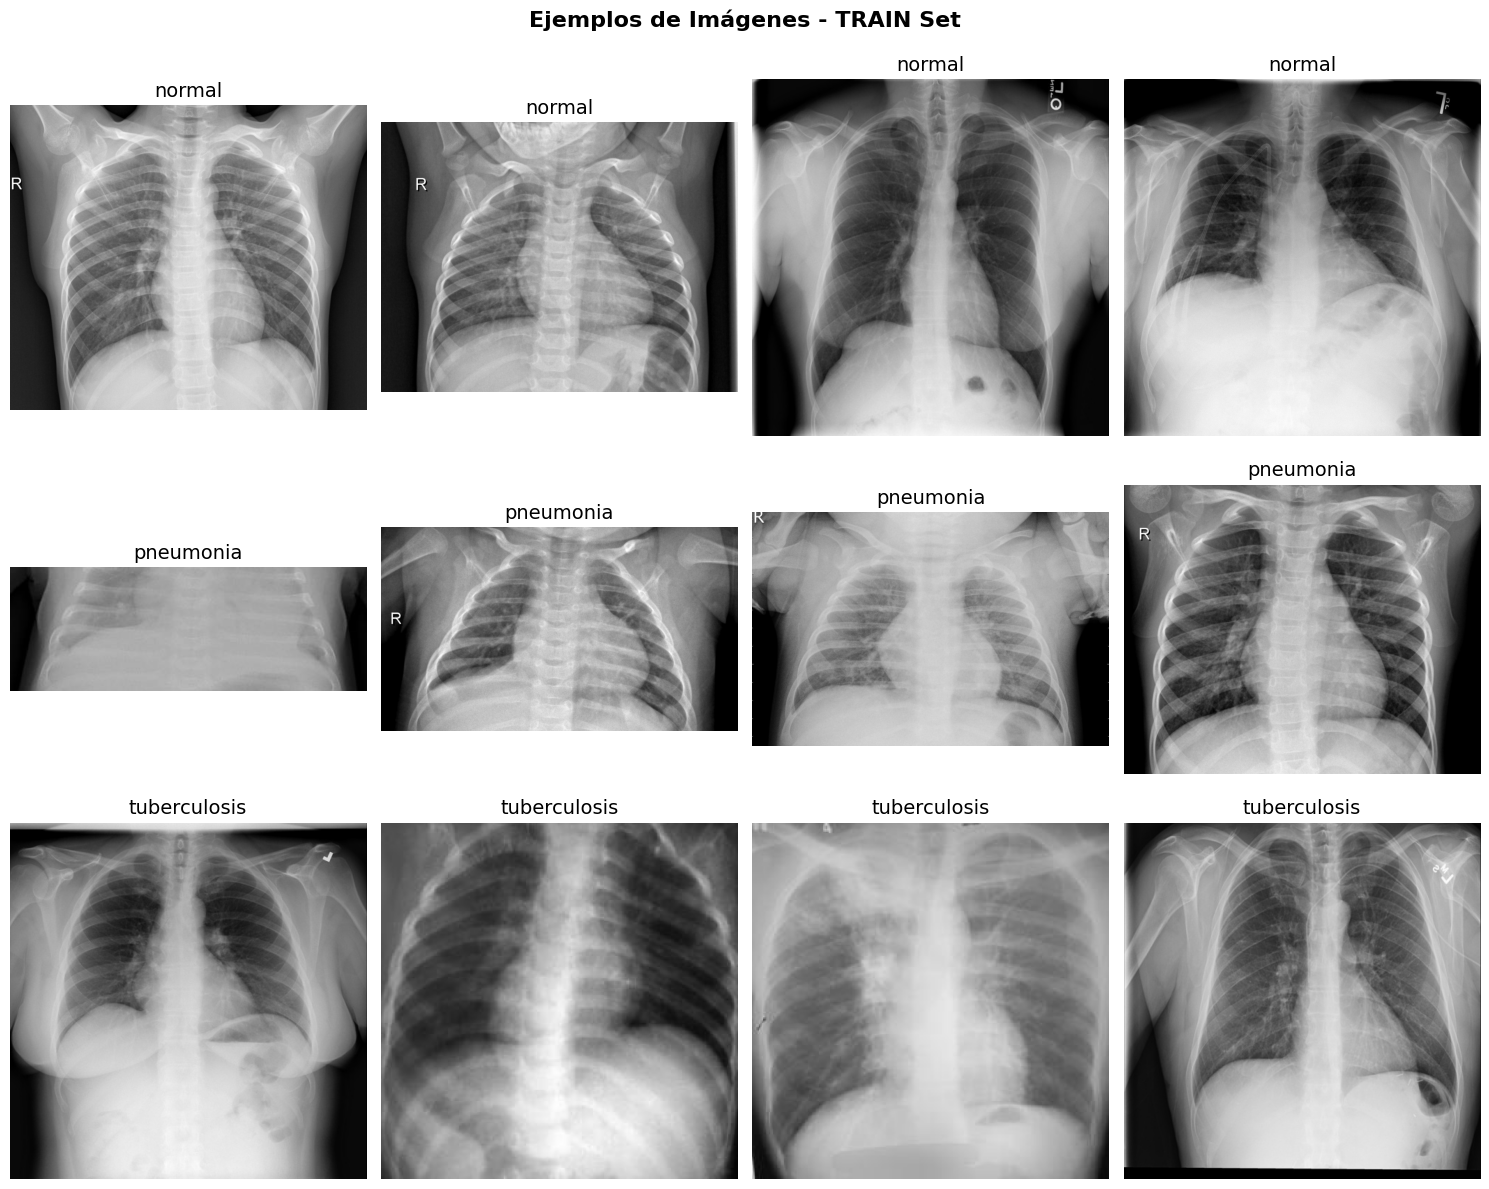

In [43]:
#mostrar imágenes de ejemplo
import random

def show_sample_img(data_path, split='train', samples_per_class = 3):
  #Funcion que muestra imagenes de ejemplo de cada clase
  data_path = Path(data_path)
  classes= ['normal', 'pneumonia', 'tuberculosis']

  fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15,12))
  fig.suptitle(f"Ejemplos de Imágenes - {split.upper()} Set", fontsize  = 16, fontweight = 'bold', y=0.995)

  for i, class_name in enumerate(classes):
    class_path = data_path / split / class_name
    images = [f for f in os.listdir(class_path)
          if f.endswith(('.jpg', '.jpeg', '.png'))]
    samples = random.sample(images, min(samples_per_class, len(images)))

    for j, sample in enumerate(samples):
      img_path = class_path / sample
      img = Image.open(img_path)
      axes[i,j].imshow(img)
      axes[i,j].axis('off')
      axes[i,j].set_title(class_name, fontsize = 14)

      if j == 0:
        axes[i,j].set_ylabel(class_name, fontsize = 14)
  plt.tight_layout()
  plt.show()

show_sample_img(data_path, split = 'train', samples_per_class= 4)


In [52]:
#Analizar tamaño de las imágenes

def analyze_img_dimensions(data_path, split = 'train', sample_size = 100):
  #Analiza las dimensiones de las imágenes en el dataset
  data_path = Path(data_path)
  classes = ['normal', 'pneumonia', 'tuberculosis']
  dim = {
      'width':[],
      'height':[],
      'class':[]
  }

  for class_name in classes:
    class_path = data_path/split/class_name

    #obtener imágenes
    images = [f for f in class_path.iterdir()
          if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

    sample = random.sample(images, min(sample_size, len(images)))
    for img_path in sample:
      img = Image.open(img_path)
      width, height = img.size
      dim['width'].append(width)
      dim['height'].append(height)
      dim['class'].append(class_name)
  return pd.DataFrame(dim)

print("Analizando dimensiones de imágenes")
df_dims = analyze_img_dimensions(data_path, split='train', sample_size=200)
print("Dimensiones analizadas")

print("=" * 50)
print(df_dims.groupby('class')[['width', 'height']].describe())
print("=" * 50)


Analizando dimensiones de imágenes
Dimensiones analizadas
              width                                                      \
              count     mean         std    min     25%     50%     75%   
class                                                                     
normal        200.0   914.10  480.993465  256.0   512.0  1024.0  1024.0   
pneumonia     200.0  1335.37  375.167304  664.0  1024.0  1252.0  1574.5   
tuberculosis  200.0   369.06  186.590855  174.0   256.0   256.0   512.0   

                     height                                             \
                 max  count     mean         std    min    25%     50%   
class                                                                    
normal        2746.0  200.0  852.000  398.053530  256.0  512.0  1024.0   
pneumonia     2890.0  200.0  983.955  403.825753  322.0  678.0   876.0   
tuberculosis  2140.0  200.0  364.725  171.505335  186.0  256.0   256.0   

                              
               

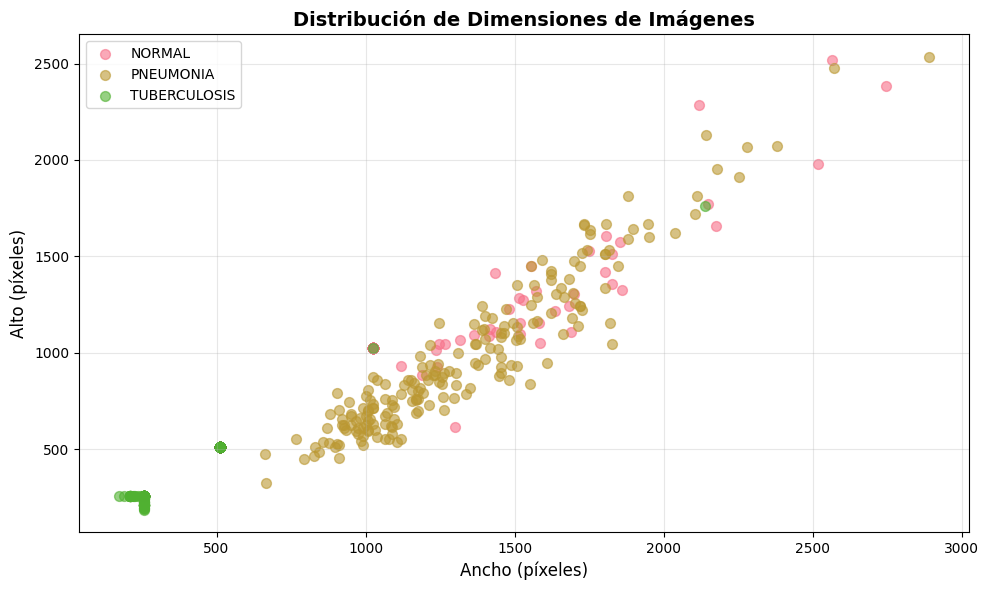


📏 Tamaño más común:
   512x512 píxeles


In [53]:
fig,ax = plt.subplots(1,1, figsize = (10,6))

for class_name in ['normal', 'pneumonia', 'tuberculosis']:
  df_class = df_dims[df_dims['class']==class_name]
  ax.scatter(df_class['width'], df_class['height'], alpha = 0.6, s=50, label = class_name.upper())

ax.set_xlabel('Ancho (píxeles)', fontsize=12)
ax.set_ylabel('Alto (píxeles)', fontsize=12)
ax.set_title('Distribución de Dimensiones de Imágenes',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Tamaño más común
print("\n📏 Tamaño más común:")
mode_width = df_dims['width'].mode()[0]
mode_height = df_dims['height'].mode()[0]
print(f"   {mode_width}x{mode_height} píxeles")


In [55]:
# Celda 9: Resumen del análisis exploratorio
print("=" * 70)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 70)

print("\n TAMAÑO DEL DATASET:")
print(f"   • Total de imágenes: {df_stats['count'].sum():,}")
print(f"   • Train: {df_stats[df_stats['split']=='train']['count'].sum():,}")
print(f"   • Validation: {df_stats[df_stats['split']=='val']['count'].sum():,}")
print(f"   • Test: {df_stats[df_stats['split']=='test']['count'].sum():,}")

print("\n DISTRIBUCIÓN DE CLASES:")
totals = df_stats.groupby('class')['count'].sum()
for class_name, count in totals.items():
    pct = (count / totals.sum()) * 100
    print(f"   • {class_name.capitalize():15s}: {count:5,} ({pct:5.1f}%)")

train_counts = df_stats[df_stats['split']=='train']['count'].values
ratio = train_counts.max() / train_counts.min()
print(f"\n BALANCE:")
print(f"   • Ratio de desbalance: {ratio:.2f}:1")
if ratio > 2:
    print(f"   • ⚠️  Significativamente desbalanceado")
elif ratio > 1.5:
    print(f"   • ⚡ Levemente desbalanceado")
else:
    print(f"   • ✅ Razonablemente balanceado")

print(f"\n DIMENSIONES DE IMÁGENES:")
print(f"   • Rango de anchos: {df_dims['width'].min()}-{df_dims['width'].max()} px")
print(f"   • Rango de altos: {df_dims['height'].min()}-{df_dims['height'].max()} px")
print(f"   • Tamaño más común: {df_dims['width'].mode()[0]}x{df_dims['height'].mode()[0]} px")

print("\n" + "=" * 70)
print("Análisis completado. Listo para preprocesamiento y entrenamiento.")
print("=" * 70)

RESUMEN DEL ANÁLISIS EXPLORATORIO DE DATOS

 TAMAÑO DEL DATASET:
   • Total de imágenes: 25,553
   • Train: 20,450
   • Validation: 2,534
   • Test: 2,569

 DISTRIBUCIÓN DE CLASES:
   • Normal         : 9,088 ( 35.6%)
   • Pneumonia      : 5,824 ( 22.8%)
   • Tuberculosis   : 10,641 ( 41.6%)

 BALANCE:
   • Ratio de desbalance: 1.82:1
   • ⚡ Levemente desbalanceado

 DIMENSIONES DE IMÁGENES:
   • Rango de anchos: 174-2890 px
   • Rango de altos: 186-2534 px
   • Tamaño más común: 512x512 px

Análisis completado. Listo para preprocesamiento y entrenamiento.
